<a href="https://colab.research.google.com/github/Tstrebe2/umich-mads-capstone-project/blob/main/tim-default-densenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys

!{sys.executable} -m pip install pydicom -q

     |████████████████████████████████| 2.0 MB 36.9 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from IPython.display import clear_output

path = '/content/drive/MyDrive/capstone/assets/stage_2_train_images.zip'

clear_output(wait=True)
!unzip {path}

In [4]:
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from torch.optim import SGD
from torch.optim.lr_scheduler import ExponentialLR
import torch
import torchvision
from torch.profiler import profile, record_function, ProfilerActivity

import pydicom as dicom
from PIL import Image

import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import os

In [6]:
class CustomImageDataset(Dataset):
  def __init__(self, annotations_file, img_dir, indices=None, transform=None, target_transform=None):
    if indices:
      self.img_labels = pd.read_csv(annotations_file).iloc[indices]
    else:
      self.img_labels = pd.read_csv(annotations_file)

    self.img_dir = img_dir
    self.transform = transform
    self.target_transform = target_transform

  def __len__(self):
    return len(self.img_labels)

  def __getitem__(self, idx):
    img_path = ''.join([os.path.join(self.img_dir, self.img_labels.iloc[idx, 0]), '.dcm'])
    
    image = dicom.dcmread(img_path)
    image = Image.fromarray(image.pixel_array).convert(mode='RGB')

    label = self.img_labels.iloc[idx, -1]

    if self.transform:
        image = self.transform(image)
    if self.target_transform:
        label = self.target_transform(label)
    return image, label

  def get_classes(self):
    return self.img_labels.iloc[:, -1].unique()

  classes = property(get_classes)

In [7]:
annotations_file = '/content/drive/MyDrive/capstone/assets/stage_2_train_labels.csv.zip'
img_dir = '/content'

label_df = pd.read_csv(annotations_file)

X_train, X_test = train_test_split(label_df, test_size=.7, stratify=label_df.Target, random_state=99)
X_train, X_val, = train_test_split(X_train, test_size=.5, stratify=X_train.Target, random_state=99)
X_train, X_val, X_test = X_train.index.tolist(), X_val.index.tolist(), (X_test
                                                                        .groupby('Target')
                                                                        .apply(lambda grp: grp.sample(2000, random_state=99))
                                                                        .droplevel(0)
                                                                        .index
                                                                        .tolist())

len(X_train), len(X_val),  len(X_test)

(4534, 4534, 4000)

In [11]:
mean = [0.5132, 0.5132, 0.5132]
std = [0.2483, 0.2483, 0.2483]

transforms = dict(
  train = torchvision.transforms.Compose([
      torchvision.transforms.Resize(256),
      torchvision.transforms.CenterCrop(256),
      torchvision.transforms.RandomHorizontalFlip(.1),
      torchvision.transforms.ToTensor(),
      torchvision.transforms.Normalize(mean, std),
  ]),
  eval = torchvision.transforms.Compose([
      torchvision.transforms.Resize(256),
      torchvision.transforms.CenterCrop(256),
      torchvision.transforms.ToTensor(),
      torchvision.transforms.Normalize(mean, std),
  ])
)

train_dataset = CustomImageDataset(annotations_file, img_dir, indices=X_train, transform=transforms['train'])
val_dataset = CustomImageDataset(annotations_file, img_dir, indices=X_val, transform=transforms['eval'])
test_dataset = CustomImageDataset(annotations_file, img_dir, indices=X_test, transform=transforms['eval'])

In [18]:
batch_size = 32

train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_data_loader = DataLoader(val_dataset, batch_size=batch_size)

print('training steps per epoch:', len(train_data_loader.dataset)//batch_size)
print('validation steps per epoch:', len(val_data_loader.dataset)//batch_size)

training steps per epoch: 141
validation steps per epoch: 141


In [10]:
# Uncomment and run to get mean and standard deviation
# for x, y in train_data_loader:
#   break

# x.mean(dim=(0, 2, 3)), x.std(dim=(0, 2, 3))

(tensor([0.5132, 0.5132, 0.5132]), tensor([0.2483, 0.2483, 0.2483]))

In [19]:
def checkpoint(model, best_loss, epoch, LR):
    print('saving')
    state = {
        'model': model,
        'best_loss': best_loss,
        'epoch': epoch,
        'rng_state': torch.get_rng_state(),
        'LR': LR
    }

    torch.save(state, '/content/checkpoint')

model = torchvision.models.densenet121(weights='DEFAULT')

# add final layer with # outputs in same dimension of labels with sigmoid
# activation
model.classifier = torch.nn.Sequential(
    torch.nn.Linear(model.classifier.in_features, 2), 
    torch.nn.LogSoftmax(dim=1))

init_learning_rate = 5e-3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)
criterion = torch.nn.NLLLoss()
optimizer = SGD(model.parameters(), lr=init_learning_rate)
scheduler = ExponentialLR(optimizer, gamma=0.9)

In [20]:
best_loss = 1e+8
best_epoch = 0
epochs = 5

for epoch in range(epochs):
  model.train()

  total_training_loss = 0
  total_val_loss = 0

  train_correct = 0
  val_correct = 0

  for x, y in train_data_loader:
    x, y = x.to(device), y.to(device)

    pred = model(x)
    loss = criterion(pred, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_training_loss += loss
    train_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    
  with torch.no_grad():
    model.eval()

    for (x, y) in val_data_loader:
      (x, y) = (x.to(device), y.to(device))
      pred = model(x)
      total_val_loss += criterion(pred, y)
      val_correct += (pred.argmax(1) == y).type(torch.float).sum().item()

  # break if no val loss improvement in 3 epochs
  if ((epoch - best_epoch) >= 3):
      print("no improvement in 3 epochs, break")
      break

  lr = next(iter(optimizer.param_groups))['lr']

  print('Epoch {} completed - train loss: {:.4f} train correct pred: {:,} val loss {:4f} val correct pred: {:,} LR: {:4f}'.format(
      epoch+1, total_training_loss, train_correct, total_val_loss, val_correct, lr 
  ))

  # checkpoint model if has best val loss yet
  if total_val_loss < best_loss:
      best_loss = total_val_loss
      best_epoch = epoch
      checkpoint(model, best_loss, epoch, lr)

  scheduler.step()

Epoch 1 completed - train loss: 69.9146 train correct pred: 3,432.0 val loss 66.831329 val correct pred: 3,479.0 LR: 0.005000
saving
Epoch 2 completed - train loss: 57.0550 train correct pred: 3,691.0 val loss 57.902977 val correct pred: 3,674.0 LR: 0.004500
saving
Epoch 3 completed - train loss: 49.5580 train correct pred: 3,832.0 val loss 57.789433 val correct pred: 3,672.0 LR: 0.004050
saving
Epoch 4 completed - train loss: 42.8451 train correct pred: 3,948.0 val loss 58.844959 val correct pred: 3,689.0 LR: 0.003645
Epoch 5 completed - train loss: 35.6039 train correct pred: 4,068.0 val loss 61.529873 val correct pred: 3,673.0 LR: 0.003281


In [21]:
  checkpoint_best = torch.load('/content/checkpoint')
  model = checkpoint_best['model']

In [22]:
test_data_loader =  DataLoader(test_dataset, batch_size=batch_size)

y_s = torch.Tensor().to(device)
preds = torch.Tensor(0, 2).to(device)

with torch.no_grad():
  model.eval()
  for i, (x, y) in enumerate(test_data_loader):
    x, y = x.to(device), y.to(device)

    pred = model(x)

    preds = torch.vstack((preds, pred))
    y_s = torch.cat((y_s, y), dim=0)

print('n true:', y_s.shape[0])
print('n predictions:', preds.shape[0])

n true: 4000
n predictions: 4000


tensor([[0.2383, 0.7617],
        [0.6178, 0.3822],
        [0.9780, 0.0220],
        ...,
        [0.2845, 0.7155],
        [0.3427, 0.6573],
        [0.2195, 0.7805]], device='cuda:0')

precision:	0.8667
recall:		0.6470
f1:		0.7409



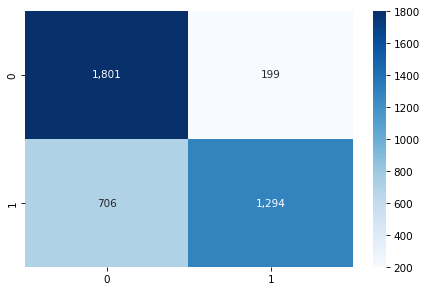

In [27]:
y_true = y_s.cpu().numpy()
y_pred = preds.cpu().numpy().argmax(axis=1)
y_proba = torch.nn.Softmax(dim=1)(preds).cpu().numpy()[:, 1]

precision = metrics.precision_score(y_true, y_pred)
recall = metrics.recall_score(y_true, y_pred)
f1 = metrics.f1_score(y_true, y_pred)

print('precision:\t{:.4f}'.format(precision))
print('recall:\t\t{:.4f}'.format(recall))
print('f1:\t\t{:.4f}'.format(f1))
print()

fig = plt.figure(dpi=75)
ax = plt.gca()
sns.heatmap(metrics.confusion_matrix(y_true, y_pred), annot=True, fmt=',', cmap='Blues')
fig.tight_layout()
fig.show()

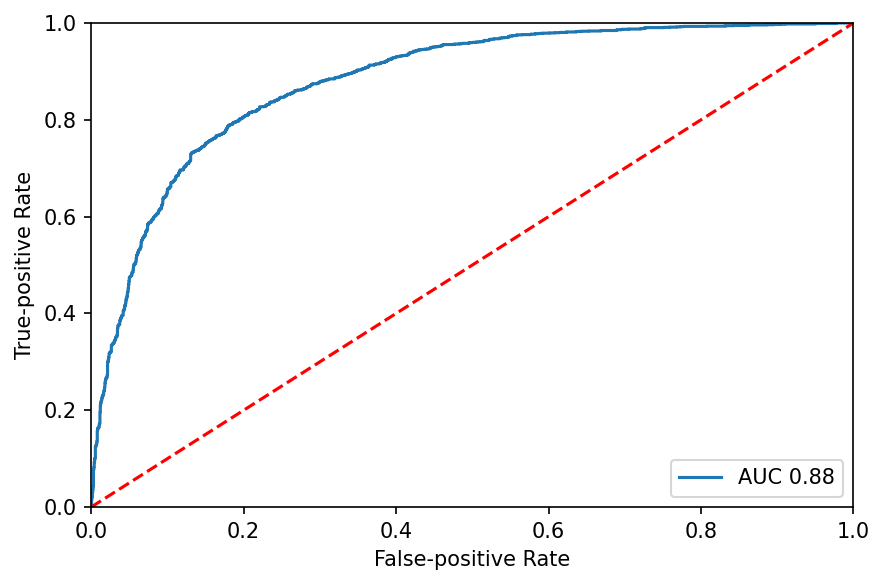

In [28]:
fpr, tpr, _ = metrics.roc_curve(y_true, y_proba)
roc_auc_score = metrics.roc_auc_score(y_true, y_proba)

no_skill = np.linspace(0, 1, 100)

plt.figure(dpi=150)
plt.plot(fpr, tpr, label='AUC {:.2f}'.format(roc_auc_score))
plt.plot(no_skill, no_skill, '--r')
plt.legend(loc='lower right')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.ylabel('True-positive Rate')
plt.xlabel('False-positive Rate')
plt.tight_layout()
plt.show()

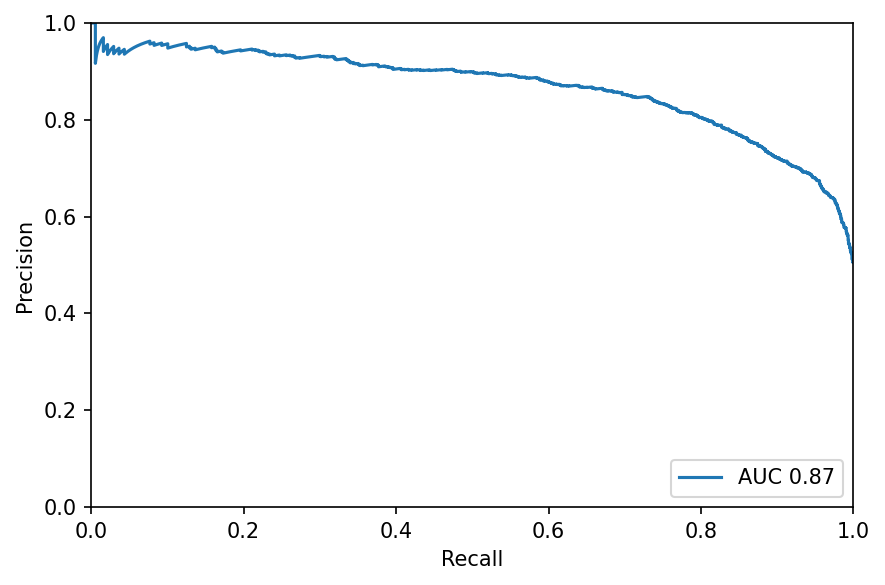

In [29]:
precision, recall, _ = metrics.precision_recall_curve(y_true, y_proba)
auprc_score = metrics.auc(recall, precision)

plt.figure(dpi=150)
plt.plot(recall, precision, label='AUC {:.2f}'.format(auprc_score))
plt.legend(loc='lower right')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.tight_layout()
plt.show()